In [30]:
import numpy as np
import pandas as pd
import os

from tvb.simulator.lab import *
import sys
import scipy.io
import tvbsim
from tvbsim.exp import clinregions

np.random.seed(123456789)

# plotting fxns
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# set all directories
root_dir = os.path.join('/Users/adam2392/Documents/pydata/metadata')
root_dir = os.path.join('/Volumes/ADAM LI/rawdata/tvbpipeline/')

patient = 'id001_ac'
patient='id002_cj'
patient = 'id003_cm'
patient = 'id004_cv'
patient = 'id005_et'
# patient = 'id006_fb'
# patient='id008_gc'
# patient = 'id007_fo'
# patient = 'id009_il'
# patient = 'id010_js'
# patient = 'id011_ml'
# patient = 'id012_pc'
# patient ='id013_pg'
# patient = 'id014_rb'
# patient = 'id015_sf'

patient = 'id001_bt'
expname = 'exp013'

metadatadir = os.path.join(root_dir)
outputdatadir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/', expname)
if not os.path.exists(outputdatadir):
    os.makedirs(outputdatadir)

seegmetadatadir = os.path.join(metadatadir, patient, 'elec')
tvbmetadatadir = os.path.join(metadatadir, patient, 'tvb')
seegfile = os.path.join(seegmetadatadir, 'seeg.txt')
gainfile = os.path.join(seegmetadatadir, 'gain_inv-square.txt')
ezhypfile = os.path.join(tvbmetadatadir, 'ez_hypothesis.txt')

tvbsim.util.renamefiles(seegmetadatadir)

# get the important files
getfilepath = lambda filename: os.path.join(metadatadir, filename)
# seegfile = getfilepath('seeg.txt')
# gainfile = getfilepath('gain_inv-square.txt')
# surffile = getfilepath

print(seegfile)

Already renamed seeg.xyz possibly!
Already renamed gain_inv-square.mat possibly!
/Volumes/ADAM LI/rawdata/tvbpipeline/id001_bt/elec/seeg.txt


In [17]:
# initialize structural connectivity and main simulator object
con = connectivity.Connectivity.from_file(os.path.join(tvbmetadatadir, "connectivity.zip"))
maintvbexp = tvbsim.MainTVBSim(con, condspeed=np.inf)
# load the necessary data files to run simulation
maintvbexp.loadseegxyz(seegfile=seegfile)
maintvbexp.loadgainmat(gainfile=gainfile)
maintvbexp.loadsurfdata(directory=tvbmetadatadir, use_subcort=False)

reginds = pd.read_csv(ezhypfile, delimiter='\n').as_matrix()
ezinds = np.where(reginds==1)[0]
ezregions = con.region_labels[ezinds]
pzregions = []
print(sum(ezinds))
print(ezregions)

# set ez/pz regions
# pzregions = []
# ezregions = []
maintvbexp.setezregion(ezregions=ezregions)
maintvbexp.setpzregion(pzregions=pzregions)
print(maintvbexp.ezind)
print(maintvbexp.ezregion)
print(maintvbexp.pzregion)
print(maintvbexp.conn.speed)

WARNING  File 'hemispheres' not found in ZIP.
NOT USING SUBCORT
91
['Right-Pallidum' 'Right-Hippocampus']
[45 46]
['Right-Pallidum' 'Right-Hippocampus']
None
[inf]


In [18]:
# allindices = np.hstack((maintvbexp.ezind, maintvbexp.pzind)).astype(int) 
# print(allindices)
# # print(maintvbexp.conn.region_labels)
# print(maintvbexp.conn.region_labels[80])
# # 'Right-Hippocampus','Right-Amygdala', 
# #           'ctx-rh-middletemporal','ctx-rh-entorhinal'
# # print(np.where(maintvbexp.conn.region_labels == 'Right-Hippocampus'))
# print(np.where(maintvbexp.conn.region_labels == 'ctx-rh-rostralmiddlefrontal'))

In [19]:
# allclinregions = ezregions + pzregions
# for idx, ezregion in enumerate(allclinregions):

#     # set ez/pz regions
#     maintvbexp.setezregion(ezregions=[ezregion])
#     maintvbexp.setpzregion(pzregions=[])
    
#     print(maintvbexp.ezind, maintvbexp.pzind)
#     print(maintvbexp.ezregion)

In [20]:
# setup models and integrators
######### Epileptor Parameters ##########
# epileptor_r = 0.00035        # Temporal scaling in the third state variable
# epiks = -10                  # Permittivity coupling, fast to slow time scale
# epitt = 0.07                   # time scale of simulation
# epitau = 10                 # Temporal scaling coefficient in fifth st var
# x0norm=-2.35 # x0c value = -2.05
# x0ez=-1.65
# x0pz=-2.0
# if maintvbexp.ezregion is None:
#     x0ez = None
# if maintvbexp.pzregion is None:
#     x0pz = None
    
######### Epileptor Parameters ##########
epileptor_r = 0.00037        # Temporal scaling in the third state variable
epiks = -10                  # Permittivity coupling, fast to slow time scale
epitt = 0.07                   # time scale of simulation
epitau = 10                   # Temporal scaling coefficient in fifth st var
x0norm=-2.45 # x0c value = -2.05
x0ez=-1.65 # -1.8
x0pz=-1.9 # -1.925
# x0pz = None

if maintvbexp.ezregion is None:
    x0ez = None
if maintvbexp.pzregion is None:
    x0pz = None    
    
######### Integrator Parameters ##########
# parameters for heun-stochastic integrator
heun_ts = 0.05
noise_cov = np.array([0.001, 0.001, 0.,\
                      0.0001, 0.0001, 0.])*1.
ntau = 0
# noise_cov = np.array([1.001, 1.001, 0.,\
#                       1.0001, 1.0001, 0.])*1.2
# simulation parameters
_factor = 1
_samplerate = 1000*_factor # Hz
sim_length = 60*_samplerate    
period = 1./_factor

maintvbexp.initepileptor(x0norm=x0norm, x0ez=x0ez, x0pz=x0pz,
                        r=epileptor_r, Ks=epiks, tt=epitt, tau=epitau)
maintvbexp.initintegrator(ts=heun_ts, noise_cov=noise_cov, ntau=ntau)

In [21]:
dist = -1
# for ind in maintvbexp.ezind:
#     new_seeg_xyz, elecindicesmoved = maintvbexp.move_electrodetoreg(ind, dist)
# print(elecindicesmoved)
# print(maintvbexp.seeg_labels[elecindicesmoved])

# maintvbexp._computeinitcond(-2.05, 84)

# # simplegain = maintvbexp.simplest_gain_matrix()
# # maintvbexp.gainmat = simplegain
# # gainmat = maintvbexp.gain_matrix_inv_square()
# # maintvbexp.gainmat = gainmat

print(maintvbexp.gainmat.shape)
print(x0ez)
print(x0pz)
print(maintvbexp.getepileptorparams())
# if dist < 1:
#     dist = 0

(161, 84)
-1.65
None
{'ntau': 0.0, 'tau': array([10]), 'nsig': array([0.001 , 0.001 , 0.    , 0.0001, 0.0001, 0.    ]), 'tt': array([0.07]), 'ks': array([-10]), 'r': array([0.00037]), 'x0': array([-2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -1.65, -1.65, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45])}


In [22]:
# print(maintvbexp.init_cond.shape)

# N = len(maintvbexp.conn.region_labels)
# x1_init = -1.6*np.ones((1,N) )
# x2_init = -1*np.ones((1,N))
# z_init = 3.8*np.ones((1,N))
# y1_init = -13*np.ones((1,N))
# y2_init = 0.002*np.ones((1,N))
# u_init =  -0.17*np.ones((1,N))

# initcond = np.concatenate((x1_init, x2_init, z_init, 
#                            y1_init, y2_init, u_init), axis=0)
# print(initcond.shape)
# initcond = initcond.reshape((1,initcond.shape[0], initcond.shape[1],1))
# print(initcond.shape)

In [23]:
# initcond = None
configs = maintvbexp.setupsim(a=1., period=period, moved=False)
display(configs)
times, epilepts, seegts = maintvbexp.mainsim(sim_length=sim_length)

initial_conditions,None
coupling,Difference(a=1)
stimulus,None
integrator,"HeunStochastic(dt=0.05, noise=Additive(dt=0.05, ntau=0))"
surface,None
connectivity,"Connectivity(bound=False, value=None)"
conduction_speed,3.0
simulation_length,1000.0
model,"Epileptor(bound=False, value=None)"
monitors,"[TemporalAverage(bound=False, value=None), iEEG(bound=False, value=None)]"


In [24]:
allindices = np.append(maintvbexp.ezind, maintvbexp.pzind, axis=0).astype(int)
secstoreject = 15
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
times, epits, seegts, zts = postprocessor.postprocts(epilepts, seegts, times, secstoreject=secstoreject)

# secstoreject = 0
# times, epits, seegts, zts = postprocessor.postprocts_2(epits, seegts, zts, times, secstoreject=secstoreject)
# _, epits, _, _ = postprocessor.postprocts_2(epits, seegts, zts, times, secstoreject=secstoreject)

In [46]:
# GET ONSET/OFFSET OF SEIZURE
# postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
# settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=100, delta=0.5)# get the actual seizure times and offsets
# seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

detector = tvbsim.postprocess.detectonsetoffset.DetectShift()
settimes = detector.getonsetsoffsets(epits, allindices)
seizonsets, seizoffsets = detector.getseiztimes(settimes)

# APPLY BANDPASS FILTERING FOR THE RAW SEEG
freqrange = [0.1, 499]
# linefreq = 60
noisemodel = tvbsim.postprocess.filters.FilterLinearNoise(samplerate=_samplerate)
seegts = noisemodel.filter_rawdata(seegts, freqrange)
# seegts = noisemodel.notchlinenoise(seegts, freq=linefreq)
print(epits.shape)
print(seegts.shape)
print(zip(seizonsets,seizoffsets))

[    0.  2910. 13353. 19318. 30060. 39045.]
[ 2455.  8232. 18011. 26325. 35509.    nan]
returning cuz prevoffset is nan!
(84, 45000)
(161, 45000)
[(0.0, 2455.0), (2910.0, 8232.0), (13353.0, 18011.0), (19318.0, 26325.0), (30060.0, 35509.0)]


In [114]:
metadata = {
        'x0ez':x0ez,
        'x0pz':x0pz,
        'x0norm':x0norm,
        'regions': maintvbexp.conn.region_labels,
        'regions_centers': maintvbexp.conn.centres,
        'chanlabels': maintvbexp.seeg_labels,
        'seeg_xyz': maintvbexp.seeg_xyz,
        'ezregs': maintvbexp.ezregion,
        'pzregs': maintvbexp.pzregion,
        'ezindices': maintvbexp.ezind,
        'pzindices': maintvbexp.pzind,
        'onsettimes':seizonsets,
        'offsettimes':seizoffsets,
        'patient':patient,
        'epiparams': maintvbexp.getepileptorparams(),
        'gainmat': maintvbexp.gainmat
    }

# if dist != -1:
filename = os.path.join(outputdatadir, 
        '{}_dist{}.npz'.format(patient, dist))
npfile = open(filename, 'wb')
# save tseries
np.savez_compressed(npfile, epits=epits, seegts=seegts, \
         times=times, zts=zts, metadata=metadata)

print("file saved at: ", filename)

('file saved at: ', '/Users/adam2392/Documents/pydata/tvbforwardsim/stableic/id005_et_dist-1.npz')


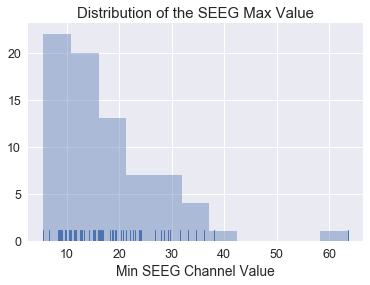

In [115]:
sigvals = []
for idx, sig in enumerate(seegts):
    sigvals.append(np.max(sig))

# print(sigvals)
    
fig = plt.figure()
sns.set(font_scale=1.25)
sns.distplot(np.multiply(sigvals,1), kde=False, rug=True,
             axlabel='Min SEEG Channel Value')
plt.title('Distribution of the SEEG Max Value')
ax = plt.gca()
# ax.set_xticks(np.arange(0,60,5))

# Apply Visualization of The Data

In [116]:
dist = -1
filename = os.path.join(outputdatadir, 
        '{}_dist{}.npz'.format(patient, dist))
npfile = open(filename, 'r')
# save tseries
# np.savez_compressed(npfile, epits=epits, seegts=seegts, \
#          times=times, zts=zts, metadata=metadata)
data = np.load(npfile)
epits = data['epits']
seegts = data['seegts']
times = data['times']
zts = data['zts']
metadata = data['metadata'].item()

print(filename)
print(metadata.keys())
ezind = metadata['ezindices']
pzind = metadata['pzindices']
seizonsets = metadata['onsettimes']
seizoffsets = metadata['offsettimes']
region_labels = metadata['regions']
regions_centers = metadata['regions_centers']
chanlabels = metadata['chanlabels']
seeg_xyz = metadata['seeg_xyz']
ezreg = metadata['ezregs']
pzreg = metadata['pzregs']
ezind = metadata['ezindices']
pzind = metadata['pzindices']
epiparams = metadata['epiparams']

# get the onsettimes and offsettimes for ez/pz indices
# allindices = np.append(ezind, pzind, axis=0).astype(int)
# postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
# settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=100, delta=0.2)# get the actual seizure times and offsets
# seizonsets, seizoffsets = postprocessor.getseiztimes(settimes, epsilon=0)
print(epiparams)

/Users/adam2392/Documents/pydata/tvbforwardsim/stableic/id005_et_dist-1.npz
['gainmat', 'x0norm', 'x0pz', 'pzregs', 'epiparams', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'offsettimes', 'ezregs', 'onsettimes', 'pzindices', 'patient', 'ezindices', 'chanlabels']
{'ntau': 0.0, 'tau': array([10]), 'nsig': array([[[0.001 ]],

       [[0.001 ]],

       [[0.    ]],

       [[0.0001]],

       [[0.0001]],

       [[0.    ]]]), 'tt': array([0.07]), 'ks': array([-10]), 'r': array([0.00037]), 'x0': array([-2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -1.9 , -1.65, -2.45, -1.65, -2.45, -2.45, -2.45,
       -1.9 , -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45, -2.45,
       -

In [117]:
# metadata = {
#         'x0ez':x0ez,
#         'x0pz':x0pz,
#         'x0norm':x0norm,
#         'regions': region_labels,
#         'regions_centers': regions_centers,
#         'chanlabels': chanlabels,
#         'seeg_xyz': seeg_xyz,
#         'ez': ezreg,
#         'pz': pzreg,
#         'ezindices': ezind,
#         'pzindices': pzind,
#         'onsettimes':seizonsets,
#         'offsettimes':seizoffsets,
#         'patient':patient,
#         'epiparams': epiparams,
#     }

# # if dist != -1:
# filename = os.path.join(outputdatadir, 
#         patient+'_dist' + str(dist) + '_.npz')
# npfile = open(filename, 'wb')
# # save tseries
# np.savez_compressed(npfile, epits=epits, seegts=seegts, \
#          times=times, zts=zts, metadata=metadata)

In [118]:
# apply manual offsetting based on the epileptor source signals
# seizonsets[1] = seizonsets[1] + 100

# GET ONSET/OFFSET OF SEIZURE
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=2000, delta=0.2)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes)

print(settimes)
print(seizonsets)
print(seizoffsets)
print(ezreg)
print(pzreg)

# seizonsets = [seizonsets[0]]
# seizoffsets = [seizoffsets[-1]]

[ 2550.  8800. 14959. 18250. 20442.    nan]
[ 7931. 13636.  4655. 23890. 22905. 19080.]
[[ 2550.  7931.]
 [ 8800. 13636.]
 [14959.  4655.]
 [18250. 23890.]
 [20442. 22905.]
 [   nan 19080.]]
[2550.0, 8800.0, 14959.0, 18250.0]
[7931.0, 13636.0, 4655.0, 23890.0]
['ctx-lh-posteriorcingulate' 'ctx-lh-precuneus']
['ctx-lh-postcentral' 'ctx-lh-superiorparietal']


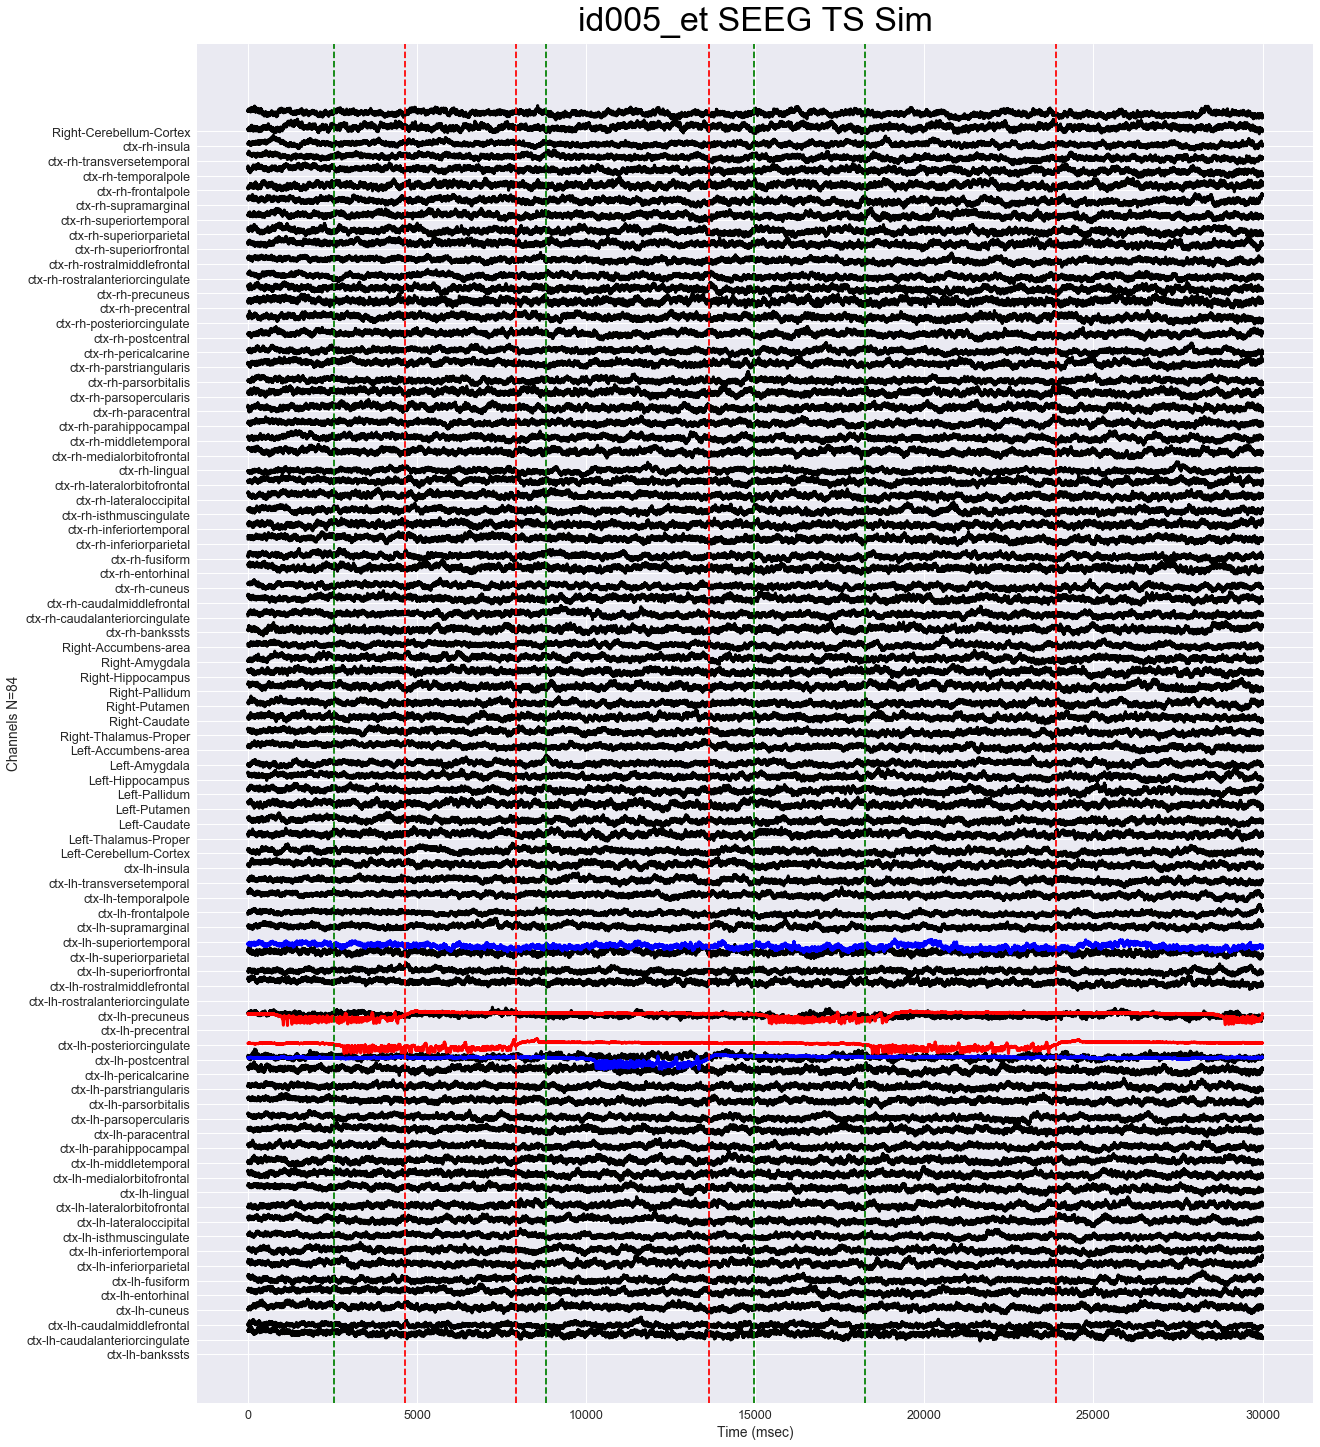

In [119]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=epits,ylabels=region_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True, titlestr='{} SEEG TS Sim'.format(patient))
# tsviz.plotvertlines(onsettimes=settimes[:,0], offsettimes=settimes[:,1])
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
tsviz.colorts(ezind, color='red')
tsviz.colorts(pzind, color='blue')

In [72]:
brainplotter = tvbsim.visualize.plotbrain.VisualBrain()
brainplotter.setfigsize(figsize=(20,17))
brainplotter.loadsurf(maintvbexp.vertices)
brainplotter.loadseeg(maintvbexp.seeg_xyz, maintvbexp.seeg_labels)
brainplotter.loadregs(maintvbexp.conn.centres, maintvbexp.conn.region_labels)
brainplotter.setcontacts()

('Nbre_contacts_per_electrode:', [8, 8, 8, 8, 10, 10, 13, 12, 8, 10, 13, 10, 9])
('Nbre_electrodes:', 13)
('Ending Index of electrodes:', array([  8,  16,  24,  32,  42,  52,  65,  77,  85,  95, 108, 118, 127]))


In [ ]:
print(patient)
sns.set(font_scale=2.0)
brainplotter.plotcontactsinbrain(maintvbexp.ezind, maintvbexp.pzind)
#                                  titlestr='SEEG Implantation For ID001_PG (Success)')

In [ ]:
tsviz = tvbsim.visualize.plotts.VisualTs()
tsviz.loaddata(data=seegts,ylabels=maintvbexp.seeg_labels)
# visualize seegts
tsviz.setfigsize(figsize=(20,25))
fig, ax = tsviz.plotts(normalize=True)
tsviz.plotvertlines(onsettimes=seizonsets, offsettimes=seizoffsets)
# tsviz.colorts(maintvbexp.ezind, color=colors[0])

Skipping this index 75
[ 2199  5979  6557 12137 19496 22530]
[10649 11916 10603 21232 24114 28871]
59
0.9250151001481846
80
1.022934643954787
75
0.12318975298969281
74
1.0351141205006207
10
1.109765568878554


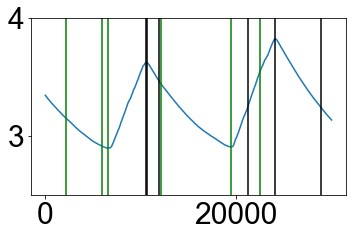

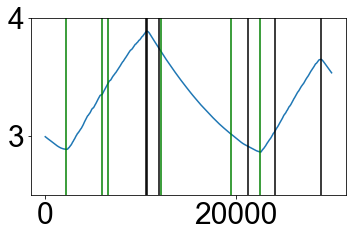

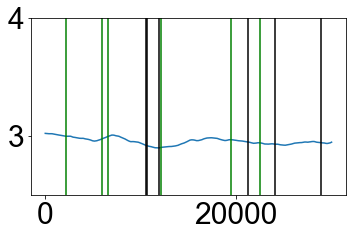

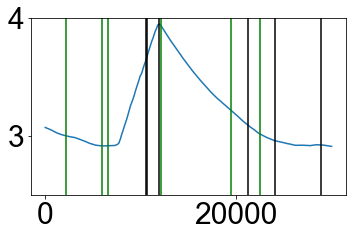

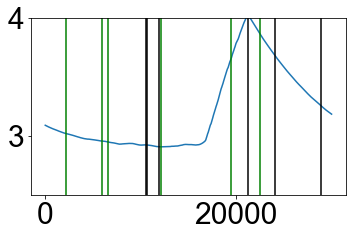

In [22]:
# get the onsettimes and offsettimes for ez/pz indices
allindices = np.append(ezind, pzind, axis=0).astype(int)
postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=100, delta=0.2)# get the actual seizure times and offsets
seizonsets, seizoffsets = postprocessor.getseiztimes(settimes, epsilon=0)

for ind in allindices:
    print(ind)
    print(np.ptp(zts[ind,:]))
    plt.figure()
    plt.plot(zts[ind,:])
    
    seizonsets = settimes[:,0]
    seizoffsets = settimes[:,1]
    for onset in seizonsets:
        plt.axvline(onset, color='green')
    for offset in seizoffsets:
        plt.axvline(offset, color='black')
    plt.ylim([2.5, 4.0])
    plt.tight_layout()

6.912231022526388e+17
(70, 70)


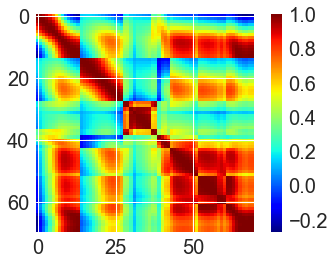

In [52]:
winsizems = 2500
corr = np.corrcoef(seegts[:, 0:winsizems])
# corr = np.cov(seegts[:, 0:winsizems])
print(np.linalg.cond(corr))
print(corr.shape)
plt.imshow(corr, cmap='jet')
plt.colorbar()

[[27527 28801]]
[[16709. 17306.]
 [17947. 18656.]
 [19794. 20534.]
 [21091. 21604.]
 [22097. 23159.]
 [52565.    nan]]
[[ 1170   452]
 [ 4244  2339]
 [ 5566  4911]
 [ 6853  6221]
 [ 7750  7453]
 [ 8647  8512]
 [10098  9860]
 [11661 11211]
 [20873 13046]
 [24750 20961]
 [27928 24774]
 [31839 28637]
 [32953 31893]
 [35296 33085]
 [37789 35424]
 [40320 38744]
 [43963 40442]
 [47088 44073]
 [51803 47340]
 [56904 52410]]
[[  757.   347.]
 [ 2383.  1707.]
 [ 3398.  2878.]
 [ 5461.  4549.]
 [ 7626.  7360.]
 [ 8821.  8656.]
 [14992. 14361.]
 [19391. 18508.]
 [20902. 19697.]
 [26496. 21285.]
 [40966. 27178.]
 [44670. 41109.]
 [47332. 44923.]
 [48785. 47934.]
 [52733. 49845.]
 [   nan 57548.]]
[[46840 49177]
 [51619 52770]]


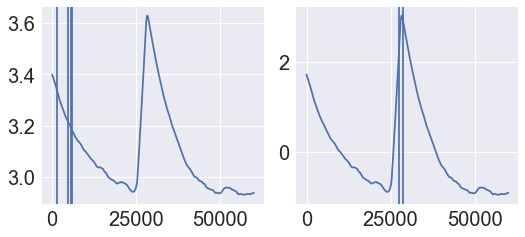

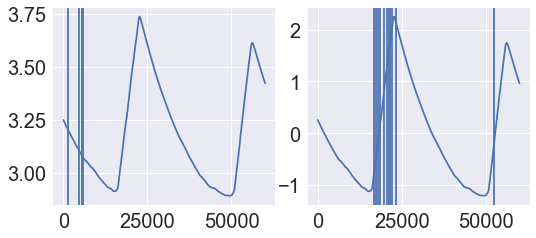

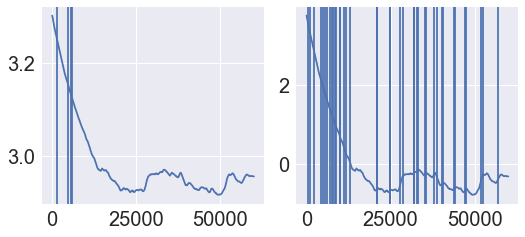

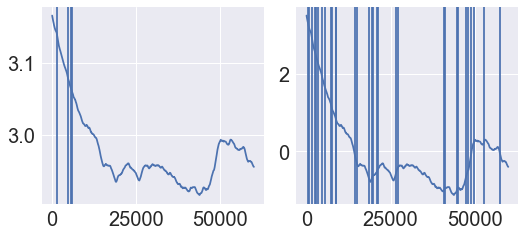

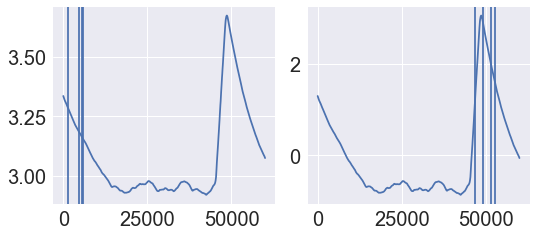

In [121]:
from sklearn.preprocessing import StandardScaler
# pzind = maintvbexp.pzind
# ezind = maintvbexp.ezind
scaler = StandardScaler()
tempzts = zts


for ind in pzind:
    plt.figure(figsize=(8,4))
    ''' PLOT THE SECOND PLOT WITH THE PROCESSED SIGNAL TO GET THE PEAKS '''
    plt.subplot(121)
    
    signal = zts[ind, :].squeeze()
#     diffzts = postprocessor.processz(signal)
    plt.plot(signal)
    settimes = postprocessor._findonsetoffset(diffzts,lookahead=100,delta=0.5)
    for i in settimes:
        try:
            plt.axvline(i[0])
            plt.axvline(i[1])
        except:
            print('not all onset/offset')
    plt.tight_layout()
    
    plt.subplot(122)
    allindices = [ind]
    postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
    settimes = postprocessor.getonsetsoffsets_new(zts, allindices, lookahead=10, delta=0.2)# get the actual seizure times and offsets
    signal = scaler.fit_transform(zts[ind,:].reshape(-1, 1))
#     minsig = np.min(signal.ravel())
#     signal[abs(signal) < abs(minsig*0.9)] = 0
    plt.plot(signal)
    for i in settimes:
        try:
            plt.axvline(i[0])
            plt.axvline(i[1])
        except:
            print('not all onset/offset')
#     print(settimes)
#     for i in settimes:
#         plt.axvline(i[0], color='green')
#         plt.axvline(i[1], color='red')
    
# for ind in ezind:
#     plt.figure(figsize=(8,4))
#     plt.subplot(121)
#     allindices = [ind]
#     postprocessor = tvbsim.postprocess.PostProcessor(samplerate=_samplerate, allszindices=allindices)
#     settimes = postprocessor.getonsetsoffsets(zts, allindices, lookahead=500, delta=1)# get the actual seizure times and offsets
#     plt.plot(scaler.fit_transform(zts[ind,:].reshape(-1, 1)))
#     print(settimes)
#     for i in settimes:
#         plt.axvline(i[0], color='green')
#         plt.axvline(i[1], color='red')
        
#     plt.subplot(122)
#     plt.plot(np.diff(tempzts[ind, :].squeeze(), n=2))
#     plt.tight_layout()


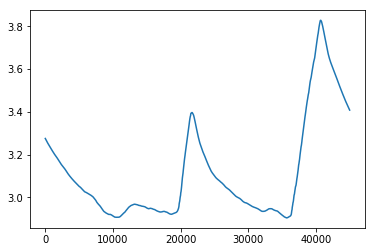

In [24]:
plt.plot(zts[pzind[0],:])

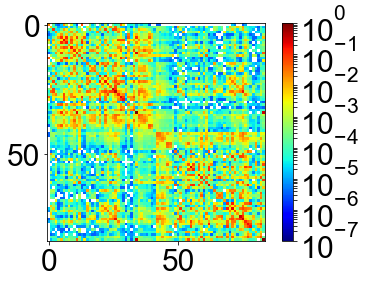

In [35]:
from matplotlib import colors, cm
plt.figure()
image = maintvbexp.conn.weights
norm = colors.LogNorm(1e-7, image.max()) #, clip='True')
plt.imshow(image, norm=norm, cmap=cm.jet)
plt.colorbar()
#max(con.weights[con.weights != 0])